In [1]:
import torch
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import time
import networkx as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from best_params import best_params_dict, default_args
import data as dt

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [2]:
%matplotlib inline

In [3]:
reload(dt)

<module 'data' from '/Users/jvs47/Documents/University/GraphAlgo/graph-neural-pde/src/data.py'>

In [4]:
from GNN import GNN
from GNN_KNN import GNN_KNN
from run_GNN import get_optimizer, train, test

In [5]:
device = torch.device("cpu")
# opt = {'self_loop_weight': 1, 'leaky_relu_slope': 0.2, 'heads': 2, 'K': 10,
#         'attention_norm_idx': 0, 'simple': True, 'alpha': 0, 'alpha_dim': 'sc', 'beta_dim': 'sc',
#         'hidden_dim': 64, 'block': 'attention', 'function': 'laplacian', 'alpha_sigmoid': True, 'augment': False, 'adjoint': False,re
#         'tol_scale': 70, 'time': 20, 'input_dropout': 0.5, 'dropout': 0.2, 'method': 'dopri5', 'optimizer':'adam', 'lr':0.008,
#         'decay':0.007, 'epoch':30, 'kinetic_energy':None, 'jacobian_norm2':None, 'total_deriv':None, 'directional_penalty':None}
best_opt = best_params_dict['Cora']
opt = {
    **default_args,
    **best_opt
}
# opt = {**default_args}
print(len(opt.keys()))

98


In [6]:
# dataset = dt.get_dataset('Cora', '../data', use_lcc=True)
dataset = dt.get_dataset(opt, '../data', opt['not_lcc'])
# dataset = dt.get_dataset({'dataset':'Cora', 'rewiring' : None}, '/content/graph-neural-pde/data', use_lcc=True) 
print(dataset.data.num_nodes, dataset.data.num_edges)

2485 10138


In [7]:
from torchinfo import summary
model, dat = GNN(opt, dataset, device).to(device), dataset.data.to(device)
# model, dat = GNN_KNN(opt, dataset, device).to(device), dataset.data.to(device)
# summary(model)

In [8]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = get_optimizer(opt['optimizer'], parameters, lr=opt['lr'], weight_decay=opt['decay'])

In [46]:
best_val_acc = test_acc = best_epoch = 0
for epoch in range(1, opt['epoch']):
    start_time = time.time()

    loss = train(model, optimizer, dat)
    train_acc, val_acc, tmp_test_acc = test(model, dat)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        best_epoch = epoch
    log = 'Epoch: {:03d}, Runtime {:03f}, Loss {:03f}, forward nfe {:d}, backward nfe {:d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(
        log.format(epoch, time.time() - start_time, loss, model.fm.sum, model.bm.sum, train_acc, best_val_acc,
                   test_acc))
    print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d}'.format(best_val_acc, test_acc, best_epoch))

/opt/homebrew/Caskroom/miniconda/base/envs/grand/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Epoch: 001, Runtime 0.740355, Loss 0.062465, forward nfe 10304, backward nfe 0, Train: 1.0000, Val: 0.7735, Test: 0.7909
best val accuracy 0.773529 with test accuracy 0.790863 at epoch 1
Epoch: 002, Runtime 0.695591, Loss 0.099652, forward nfe 10392, backward nfe 0, Train: 0.9929, Val: 0.7824, Test: 0.8061
best val accuracy 0.782353 with test accuracy 0.806091 at epoch 2
Epoch: 003, Runtime 0.731355, Loss 0.076897, forward nfe 10480, backward nfe 0, Train: 0.9929, Val: 0.7971, Test: 0.8173
best val accuracy 0.797059 with test accuracy 0.817259 at epoch 3
Epoch: 004, Runtime 0.694514, Loss 0.094836, forward nfe 10568, backward nfe 0, Train: 0.9929, Val: 0.8162, Test: 0.8305
best val accuracy 0.816176 with test accuracy 0.830457 at epoch 4
Epoch: 005, Runtime 0.695464, Loss 0.088276, forward nfe 10656, backward nfe 0, Train: 0.9929, Val: 0.8162, Test: 0.8305
best val accuracy 0.816176 with test accuracy 0.830457 at epoch 4
Epoch: 006, Runtime 0.705594, Loss 0.091734, forward nfe 10744, b

In [10]:
attention = model.odeblock.odefunc.attention_weights
edges = model.odeblock.odefunc.edge_index
print('edges shape: {}, attention shape: {}'.format(edges.shape, attention.shape))

edges shape: torch.Size([2, 12623]), attention shape: torch.Size([12623, 8])


In [11]:
print(attention.min(), attention.mean(), attention.max())

tensor(0.0059) tensor(0.1969) tensor(0.5000)


In [12]:
atts = attention.detach().numpy()[:,0]
print(atts.shape)

(12623,)


CPU times: user 9.88 ms, sys: 5.76 ms, total: 15.6 ms
Wall time: 15.3 ms


(array([2.616e+03, 5.559e+03, 2.105e+03, 1.635e+03, 3.000e+00, 7.050e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

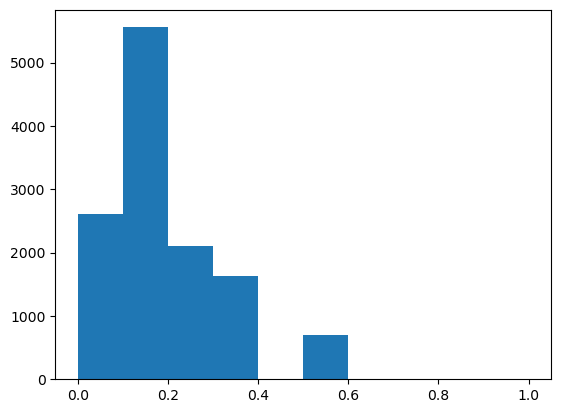

In [13]:
%%time
plt.hist(atts, bins=np.linspace(0, 1, 11))

CPU times: user 17.2 ms, sys: 42.1 ms, total: 59.3 ms
Wall time: 8.32 ms


(array([  0.,   0.,   0.,   0.,   0., 169.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 ]),
 <BarContainer object of 10 artists>)

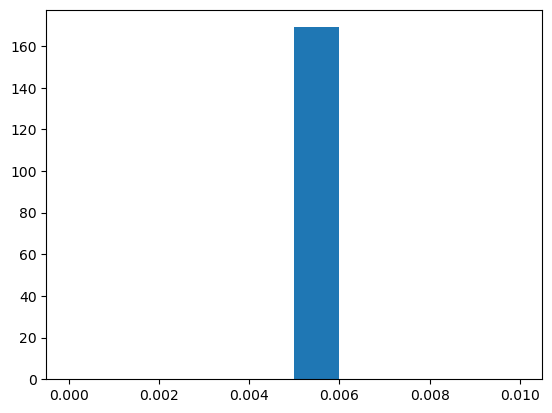

In [14]:
%%time
plt.hist(atts, bins=np.linspace(0, 0.01, 11))

In [15]:
print(attention.shape, edges.shape)

torch.Size([12623, 8]) torch.Size([2, 12623])


In [16]:
labels = dataset.data.y
print(len(labels))
print(labels.unique(return_counts=True))

2485
(tensor([0, 1, 2, 3, 4, 5, 6]), tensor([344, 214, 406, 726, 379, 285, 131]))


In [17]:
def construct_graph(edges, attention=None, threshold=0.01):
    if isinstance(edges, torch.Tensor):
        edges = edges.cpu().numpy()
    if attention is not None:
        edges = edges[:, attention > threshold]
    edge_list = zip(edges[0], edges[1])
    g = nx.Graph(edge_list)
    return g

In [18]:
edges = model.odeblock.odefunc.edge_index
g = construct_graph(edges)
# print(g.edges([32]))
print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))

7554 2485 1


CPU times: user 8.78 s, sys: 181 ms, total: 8.96 s
Wall time: 8.73 s


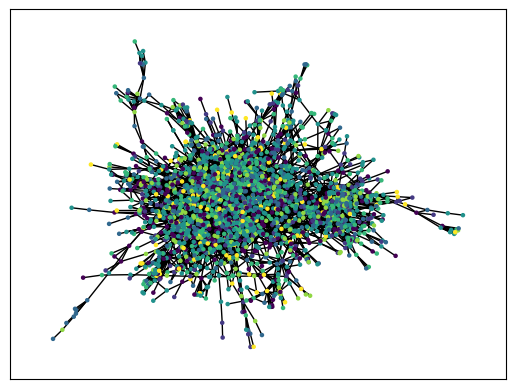

In [19]:
%%time
g.remove_edges_from(nx.selfloop_edges(g))
nx.draw_networkx(g, with_labels=False, font_weight='bold', node_size=5, node_color=labels)

In [20]:
g.remove_edges_from([(32, 387), (32, 790), (32, 791), (32, 1063), (32, 32)])
print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))

5065 2485 2


In [21]:
delete_edges = edges[:, attention[:, 0].detach().cpu().numpy() < 0.1]
print(delete_edges.shape)

torch.Size([2, 2616])


In [22]:
def remove_edges(g, edges, attention, threshold):
    if isinstance(edges, torch.Tensor):
        edges = edges.cpu().numpy()
    if isinstance(attention, torch.Tensor):
        attention = attention.detach().cpu().numpy()
    delete_edges = edges[:, attention < threshold]
    print('deleting {} edges'.format(delete_edges.shape[1]))
    edge_list = list(zip(delete_edges[0], delete_edges[1]))
    g.remove_edges_from(edge_list)
    print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))
    return g

In [23]:
g = remove_edges(g, edges, attention[:,0], threshold=0.02)
# print(g.number_of_edges(), g.number_of_nodes())

deleting 389 edges
4680 2485 39


In [24]:
g.edges([2])

EdgeDataView([(2, 1), (2, 296), (2, 1334), (2, 1531)])

In [25]:
list(g.edges)[0:10]

[(0, 575),
 (0, 1722),
 (0, 2400),
 (575, 1726),
 (1722, 852),
 (1722, 2400),
 (2400, 1068),
 (1, 2),
 (1, 592),
 (1, 593)]

In [26]:
print(g.number_of_edges(), g.number_of_nodes())

4680 2485


In [27]:
nx.number_connected_components(g)

39

In [28]:
print(edges.shape, attention.shape)

torch.Size([2, 12623]) torch.Size([12623, 8])


In [29]:
np.linspace(1, 0, 20)

array([1.        , 0.94736842, 0.89473684, 0.84210526, 0.78947368,
       0.73684211, 0.68421053, 0.63157895, 0.57894737, 0.52631579,
       0.47368421, 0.42105263, 0.36842105, 0.31578947, 0.26315789,
       0.21052632, 0.15789474, 0.10526316, 0.05263158, 0.        ])

In [30]:
np.linspace(0, 1, 20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [31]:
for threshold in np.linspace(0, 0.15, 20):
    edges = model.odeblock.odefunc.edge_index
    g = construct_graph(edges)
    attention = model.odeblock.odefunc.edge_weight
    g = remove_edges(g, edges, attention, threshold)
    comps = nx.number_connected_components(g)
    print('{} remaining edges. {} connected components at threshold {}'.format(g.number_of_edges(), comps, threshold))

deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0
deleting 169 edges
7385 2485 9
7385 remaining edges. 9 connected components at threshold 0.007894736842105263
deleting 389 edges
7165 2485 38
7165 remaining edges. 38 connected components at threshold 0.015789473684210527
deleting 477 edges
7077 2485 48
7077 remaining edges. 48 connected components at threshold 0.02368421052631579
deleting 722 edges
6836 2485 77
6836 remaining edges. 77 connected components at threshold 0.031578947368421054
deleting 841 edges
6719 2485 88
6719 remaining edges. 88 connected components at threshold 0.039473684210526314
deleting 1002 edges
6564 2485 115
6564 remaining edges. 115 connected components at threshold 0.04736842105263158
deleting 1159 edges
6412 2485 139
6412 remaining edges. 139 connected components at threshold 0.05526315789473685
deleting 1518 edges
6078 2485 202
6078 remaining edges. 202 connected components at threshold 0.06315789473684211
deleting 1

In [32]:
# for threshold in np.linspace(0, 0.01, 20):
#     edges = model.odeblock.odefunc.edge_index
#     g = construct_graph(edges)
#     attention = model.odeblock.odefunc.attention_weights[:, 0]  # just using one head for now.
#     g = remove_edges(g, edges, attention, threshold)
#     comps = nx.number_connected_components(g)
#     print('{} remaining edges. {} connected components at threshold {}'.format(g.number_of_edges(), comps, threshold))

In [33]:
print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))

3605 2485 1102


CPU times: user 8.34 s, sys: 162 ms, total: 8.5 s
Wall time: 8.54 s


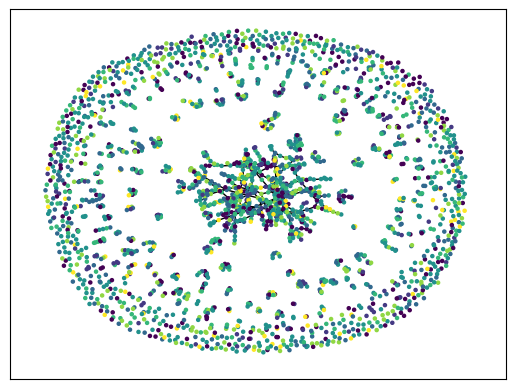

In [34]:
%%time
g.remove_edges_from(nx.selfloop_edges(g))
nx.draw_networkx(g, with_labels=False, font_weight='bold', node_size=5, node_color=labels)

In [35]:
# nx.connected_components(g)
print('connected: {}, n_components: {}, directed: {}'.format(nx.is_connected(g), nx.number_connected_components(g),
                                                             g.is_directed()))

connected: False, n_components: 1102, directed: False


In [36]:
type(atts)
print(atts.shape)
len(g.edges)

(12623,)


1531

In [37]:
# g.edges = g.edges[atts]

In [38]:
ccs = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]

In [39]:
len(ccs[0])

255

In [40]:
g0 = g.subgraph(ccs[0])

In [41]:
print(len(g0.edges), len(g0.nodes), g0.number_of_nodes())

283 255 255


In [42]:
cc_idx = list(ccs[0])

87.4 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


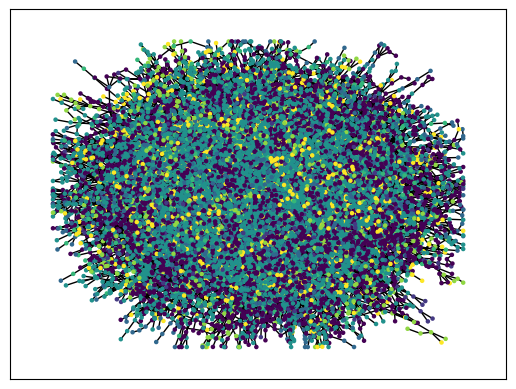

In [43]:
%%timeit
# g0.remove_edges_from(nx.selfloop_edges(g0))
nx.draw_networkx(g0, with_labels=False, font_weight='bold', node_size=5, node_color=labels[cc_idx])

In [44]:
print('connected: {}, n_components: {}, directed: {}'.format(nx.is_connected(g0), nx.number_connected_components(g0),
                                                             g0.is_directed()))

connected: True, n_components: 1, directed: False


In [45]:
# plt.savefig("path.png")